In [1]:
%matplotlib inline

# This file contains all the main external libs fastai needs
from fastai.imports import *

/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


the fastai notebooks imports all the functions into the global namespace, which I find confusing since I don't know what methods are fastai and what are coming from other libraries. 

Ideally I'd like to be able to just call `import fastai as fastai` rather than having multiple import statements. Anyways, using the defaults for now:

In [2]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [3]:
torch.cuda.is_available(), torch.backends.cudnn.enabled

(True, True)

# Data

I'm going to use a pretrained NN to solve [Kaggle's digit recognizer competition](https://www.kaggle.com/c/digit-recognizer/data), cause why not. I used https://github.com/floydwch/kaggle-cli to download the dataset, and look at the [fastai dataset.py file](https://github.com/fastai/fastai/blob/master/fastai/dataset.py) to figure out how to use it.

In [4]:
PATH = '/home/ubuntu/data/mnist/'
print(PATH)
os.listdir(PATH)

/home/ubuntu/data/mnist/


['test.csv',
 'tmp',
 'sample_submission.csv',
 'train.csv',
 '.kaggle-cli',
 'models']

Now to take a look at the data:

In [5]:
train = pd.read_csv(PATH + "train.csv")
print(train.shape)
train.head(3)

(42000, 785)


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
test = pd.read_csv(PATH+"test.csv")
print(test.shape)
test.head(3)

(28000, 784)


,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


We need the data in a form the fast.ai library can ingest, so in this case I'll pass in numpy arrays after splitting the training set into a train and validation split.

pytorch/fastai want image data to be in the same: `num_images, channels, height, width`, so I reshape the numpy arrays into 3 channel.

In [122]:
# grabbing the images from the datafram
train_images = train.iloc[:,1:].values.astype('float64') /255
# stacking them and reshaping
train_images_3D = (np.stack((train_images,)*3, -1)).reshape(-1, 3, 28, 28)
train_images_3D.shape

(42000, 3, 28, 28)

Note: when using pretrained models fastai doesn't do any data augmentation, so I've normalized the images.

Now to split into train and validation images:

In [123]:
msk = np.random.rand(len(train)) < 0.85

x_train = train_images_3D[msk]
x_val = train_images_3D[~msk]

y_train = train.iloc[:,0][msk].values.astype('int32') # only labels i.e targets digits
y_val = train.iloc[:,0][~msk].values.astype('int32') # only labels i.e targets digits

x_train.shape, y_train.shape, x_val.shape, y_val.shape

((35785, 3, 28, 28), (35785,), (6215, 3, 28, 28), (6215,))

Finally, we can make the fast.ai data object.

In [146]:
arch = resnet34 # also try resnext101_64

sz = 28 # we have 28x28x3 image size. what should this number be?

# transforms
tfms = tfms_from_model(resnet34, sz)

data = ImageClassifierData.from_arrays(PATH, trn=(x_train,y_train), 
                                       val=(x_val,y_val),)
                                       #tfms=tfms)

In [147]:
learn = ConvLearner.pretrained(arch, data, precompute=False)
learn.fit(1e-2, 3)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.710988   0.538598   0.82587   
    1      0.637675   0.454762   0.851881                    
    2      0.596391   0.433315   0.86368                     



[0.43331456, 0.8636798469387755]

In [148]:
lr = np.array([1e-4, 1e-3, 1e-2])
learn.unfreeze()
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.422605   0.340317   0.89477   
    1      0.26169    0.219956   0.929027                    
    2      0.206797   0.199699   0.935108                    
    3      0.168539   0.184376   0.940507                    
    4      0.117288   0.161206   0.949116                     
    5      0.092086   0.161702   0.951348                     
    6      0.100797   0.171211   0.949298                     



[0.17121124, 0.9492984693877551]

## finding a good learning rate

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 82%|████████▏ | 457/560 [00:08<00:01, 52.99it/s, loss=4.41]


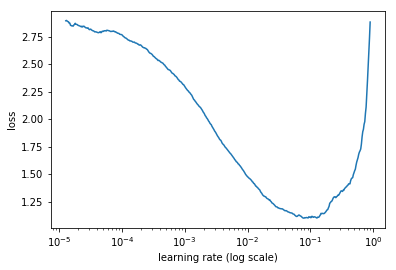

In [149]:
learn = ConvLearner.pretrained(arch, data, precompute=True)
lrf=learn.lr_find()
#learn.sched.plot_lr()
learn.sched.plot()